### CRM Sales Opportunities Analysis - Data preprocessing

**Business Context:** Multi-table CRM database preprocessing<br>
**Objective:** Clean, standardize, and prepare data for analysis<br>
**Expected Outcome:** Analysis-ready datasets with documented quality improvements



#### 1: Import required libraries 

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure plotting parameters for consistent visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("COMPREHENSIVE DATA PREPROCESSING PIPELINE")
print("=" * 60)
print("Systematic approach to data quality improvement")
print("=" * 60)

COMPREHENSIVE DATA PREPROCESSING PIPELINE
Systematic approach to data quality improvement


#### 2: Utility functions for data assessment

In [ ]:
################################################################################################################
def assess_table_quality(df, table_name):
    """
    Generate comprehensive quality metrics for a single table
    
    Returns dictionary with completeness, duplication, and type information
    This provides baseline metrics to track improvement throughout preprocessing
    """
    total_cells = df.size
    missing_cells = df.isnull().sum().sum()
    duplicate_rows = df.duplicated().sum()
    
    # Data type distribution analysis
    numeric_cols = len(df.select_dtypes(include=[np.number]).columns)
    object_cols = len(df.select_dtypes(include=['object']).columns)
    datetime_cols = len(df.select_dtypes(include=['datetime']).columns)
    
    return {
        'table_name': table_name,
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'total_cells': total_cells,
        'missing_cells': missing_cells,
        'completeness_pct': ((total_cells - missing_cells) / total_cells) * 100,
        'duplicate_rows': duplicate_rows,
        'numeric_columns': numeric_cols,
        'object_columns': object_cols,
        'datetime_columns': datetime_cols
    }

################################################################################################################
def identify_placeholder_patterns(df):
    """
    Detect common placeholder values that indicate missing data
    
    Many datasets use placeholder values instead of proper NaN
    Common patterns include: *, ?, N/A, NULL, empty strings, -1, 0 in contexts where 0 is impossible
    """
    placeholder_patterns = ['*', '?', 'N/A', 'NULL', 'null', 'none', 'NONE', '', ' ']
    placeholder_summary = {}
    
    for col in df.columns:
        col_placeholders = {}
        for pattern in placeholder_patterns:
            if df[col].dtype == 'object':
                count = (df[col].astype(str).str.strip() == pattern).sum()
                if count > 0:
                    col_placeholders[pattern] = count
        
        if col_placeholders:
            placeholder_summary[col] = col_placeholders
            
    return placeholder_summary

#### 3. Duplicate analysis and removal functions

In [ ]:
################################################################################################################
def analyze_duplicates(df, table_name, key_columns=None):
    """
    Comprehensive duplicate analysis including complete and partial duplicates
    
    key_columns: Business-relevant columns that should be unique
    Example: opportunity_id in sales data, account names in customer data
    """
    results = {
        'table_name': table_name,
        'complete_duplicates': df.duplicated().sum(),
        'key_duplicates': 0,
        'column_duplicates': {}
    }
    
    # Business key duplicates
    if key_columns:
        for col in key_columns:
            if col in df.columns:
                key_dups = df[col].duplicated().sum()
                results['key_duplicates'] += key_dups
                if key_dups > 0:
                    results['column_duplicates'][col] = key_dups
    
    # Individual column duplicate rates
    for col in df.columns:
        dup_count = df[col].duplicated().sum()
        dup_rate = (dup_count / len(df)) * 100
        results['column_duplicates'][col] = {
            'count': dup_count,
            'rate_pct': dup_rate
        }
    
    return results

################################################################################################################
def remove_duplicates(df, strategy='complete', subset_columns=None):
    """
    Remove duplicates based on specified strategy
    
    Strategies:
    - 'complete': Remove rows that are identical across all columns
    - 'subset': Remove based on specific columns (business keys)
    - 'keep_first': When duplicates exist, keep first occurrence
    - 'keep_last': When duplicates exist, keep last occurrence
    """
    original_rows = len(df)
    
    if strategy == 'complete':
        df_cleaned = df.drop_duplicates()
    elif strategy == 'subset' and subset_columns:
        df_cleaned = df.drop_duplicates(subset=subset_columns, keep='first')
    else:
        df_cleaned = df.drop_duplicates()
    
    removed_count = original_rows - len(df_cleaned)
    
    return df_cleaned, removed_count

#### 4: Missing data analysis functions

In [ ]:
################################################################################################################
def analyze_missing_patterns(df, table_name):
    """
    Comprehensive missing data pattern analysis
    
    Identifies:
    - Columns with missing data and their patterns
    - Correlations between missing values across columns
    - Business context implications
    """
    missing_summary = []
    total_rows = len(df)
    
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            missing_pct = (missing_count / total_rows) * 100
            missing_summary.append({
                'column': col,
                'missing_count': missing_count,
                'missing_percentage': missing_pct,
                'data_type': str(df[col].dtype)
            })
    
    # Missing data correlation analysis
    # High correlation between missing values suggests systematic missing patterns
    missing_corr = None
    if missing_summary:
        missing_indicators = df.isnull().astype(int)
        missing_cols = [item['column'] for item in missing_summary]
        if len(missing_cols) > 1:
            missing_corr = missing_indicators[missing_cols].corr()
    
    return {
        'table_name': table_name,
        'missing_summary': missing_summary,
        'missing_correlation': missing_corr,
        'total_missing_cells': df.isnull().sum().sum()
    }

################################################################################################################
def visualize_missing_patterns(df, table_name):
    """
    Create visualizations to understand missing data patterns
    
    Generates heatmap showing missing data patterns across rows and columns
    Helps identify systematic vs random missing patterns
    """
    if df.isnull().sum().sum() == 0:
        print(f"No missing data to visualize in {table_name}")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Missing data heatmap - sample first 100 rows for visibility
    missing_data = df.head(100).isnull()
    sns.heatmap(missing_data, cbar=True, ax=axes[0], cmap='viridis')
    axes[0].set_title(f'{table_name} - Missing Data Pattern (First 100 rows)')
    axes[0].set_xlabel('Columns')
    axes[0].set_ylabel('Rows')
    
    # Missing data bar chart
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    
    if len(missing_counts) > 0:
        missing_counts.plot(kind='bar', ax=axes[1])
        axes[1].set_title(f'{table_name} - Missing Data Count by Column')
        axes[1].set_xlabel('Columns')
        axes[1].set_ylabel('Missing Count')
        axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

#### 5: Imputation functions

In [ ]:
################################################################################################################
def numerical_imputation(series, strategy='median', group_by=None, group_data=None):
    """
    Numerical data imputation with multiple strategies
    
    Strategies:
    - 'mean': Simple mean imputation
    - 'median': Median imputation (robust to outliers)
    - 'mode': Most frequent value
    - 'group_median': Median within groups (e.g., by category)
    - 'interpolate': Linear interpolation (for time series)
    """
    if strategy == 'mean':
        return series.fillna(series.mean())
    elif strategy == 'median':
        return series.fillna(series.median())
    elif strategy == 'mode':
        mode_val = series.mode()
        return series.fillna(mode_val[0] if len(mode_val) > 0 else series.median())
    elif strategy == 'group_median' and group_by is not None and group_data is not None:
        # Group-based imputation preserves subgroup patterns
        return group_data.groupby(group_by)[series.name].transform(
            lambda x: x.fillna(x.median())
        )
    elif strategy == 'interpolate':
        return series.interpolate()
    else:
        return series.fillna(series.median())

################################################################################################################
def categorical_imputation(series, strategy='mode', custom_value=None):
    """
    Categorical data imputation strategies
    
    Strategies:
    - 'mode': Most frequent category
    - 'custom': User-specified value
    - 'unknown': Mark as 'Unknown' category
    """
    if strategy == 'mode':
        mode_val = series.mode()
        return series.fillna(mode_val[0] if len(mode_val) > 0 else 'Unknown')
    elif strategy == 'custom' and custom_value:
        return series.fillna(custom_value)
    elif strategy == 'unknown':
        return series.fillna('Unknown')
    else:
        return series.fillna('Unknown')

#### 6: Outlier detection functions

In [ ]:
################################################################################################################
def iqr_outlier_detection(series, multiplier=1.5):
    """
    Interquartile Range method for outlier detection
    
    Conservative method that identifies extreme values based on quartile spread
    multiplier: Controls sensitivity (1.5 = standard, 3.0 = very conservative)
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - (multiplier * IQR)
    upper_bound = Q3 + (multiplier * IQR)
    
    outlier_mask = (series < lower_bound) | (series > upper_bound)
    
    return {
        'outlier_mask': outlier_mask,
        'outlier_count': outlier_mask.sum(),
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outlier_indices': series.index[outlier_mask].tolist(),
        'outlier_values': series[outlier_mask].tolist()
    }

################################################################################################################
def zscore_outlier_detection(series, threshold=3):
    """
    Z-score method for outlier detection
    
    Identifies values that are more than 'threshold' standard deviations from the mean
    threshold=3 captures ~99.7% of data in normal distribution
    """
    z_scores = np.abs(stats.zscore(series.dropna()))
    outlier_mask = pd.Series(False, index=series.index)
    
    valid_indices = series.dropna().index
    outlier_mask.loc[valid_indices] = z_scores > threshold
    
    return {
        'outlier_mask': outlier_mask,
        'outlier_count': outlier_mask.sum(),
        'z_scores': z_scores,
        'threshold': threshold,
        'outlier_indices': series.index[outlier_mask].tolist(),
        'outlier_values': series[outlier_mask].tolist()
    }

################################################################################################################
def modified_zscore_outlier_detection(series, threshold=3.5):
    """
    Modified Z-score using median absolute deviation (MAD)
    
    More robust to extreme outliers than standard Z-score
    Uses median instead of mean, making it less sensitive to outliers themselves
    """
    median = series.median()
    mad = np.median(np.abs(series - median))
    
    # Avoid division by zero
    if mad == 0:
        mad = np.median(np.abs(series - series.mean()))
    
    modified_z_scores = 0.6745 * (series - median) / mad
    outlier_mask = np.abs(modified_z_scores) > threshold
    
    return {
        'outlier_mask': outlier_mask,
        'outlier_count': outlier_mask.sum(),
        'modified_z_scores': modified_z_scores,
        'threshold': threshold,
        'median': median,
        'mad': mad,
        'outlier_indices': series.index[outlier_mask].tolist(),
        'outlier_values': series[outlier_mask].tolist()
    }

################################################################################################################
def visualize_outliers(df, column, methods_results):
    """
    Create comprehensive outlier visualizations
    
    Shows distribution, boxplot, and outlier detection results
    Helps validate outlier detection methods and business decisions
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribution plot
    df[column].hist(bins=50, ax=axes[0,0], alpha=0.7)
    axes[0,0].set_title(f'{column} - Distribution')
    axes[0,0].set_xlabel(column)
    axes[0,0].set_ylabel('Frequency')
    
    # Box plot
    df[column].plot(kind='box', ax=axes[0,1])
    axes[0,1].set_title(f'{column} - Box Plot')
    axes[0,1].set_ylabel(column)
    
    # Q-Q plot for normality assessment
    stats.probplot(df[column].dropna(), dist="norm", plot=axes[1,0])
    axes[1,0].set_title(f'{column} - Q-Q Plot (Normality Check)')
    
    # Outlier comparison
    method_names = list(methods_results.keys())
    outlier_counts = [results['outlier_count'] for results in methods_results.values()]
    
    axes[1,1].bar(method_names, outlier_counts)
    axes[1,1].set_title(f'{column} - Outlier Count by Method')
    axes[1,1].set_ylabel('Number of Outliers')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

#### 7: Data transformation functions

In [ ]:
################################################################################################################
def standardize_column_names(df):
    """
    Standardize column names for consistency
    
    Converts to lowercase, replaces spaces with underscores
    Ensures consistent naming convention across datasets
    """
    df_transformed = df.copy()
    
    new_columns = []
    changes_made = False
    
    for col in df_transformed.columns:
        # Convert to lowercase and replace problematic characters
        new_col = col.lower().strip()
        new_col = new_col.replace(' ', '_').replace('-', '_').replace('.', '_')
        new_col = ''.join(char for char in new_col if char.isalnum() or char == '_')
        
        new_columns.append(new_col)
        if new_col != col:
            changes_made = True
    
    df_transformed.columns = new_columns
    
    return df_transformed, changes_made

################################################################################################################
def convert_data_types(df, type_mappings):
    """
    Convert data types based on mappings
    
    type_mappings: Dictionary mapping column names to target types
    Example: {'date_column': 'datetime64', 'numeric_column': 'float64'}
    """
    df_converted = df.copy()
    conversion_log = {}
    
    for column, target_type in type_mappings.items():
        if column in df_converted.columns:
            original_type = str(df_converted[column].dtype)
            
            try:
                if target_type == 'datetime64':
                    df_converted[column] = pd.to_datetime(df_converted[column], errors='coerce')
                elif target_type in ['float64', 'int64']:
                    df_converted[column] = pd.to_numeric(df_converted[column], errors='coerce')
                else:
                    df_converted[column] = df_converted[column].astype(target_type)
                
                conversion_log[column] = {
                    'from': original_type,
                    'to': str(df_converted[column].dtype),
                    'success': True
                }
            except Exception as e:
                conversion_log[column] = {
                    'from': original_type,
                    'to': original_type,
                    'success': False,
                    'error': str(e)
                }
    
    return df_converted, conversion_log

#### 8: Main preprocessing workflow

#### Step 1: Load all datasets

In [23]:
# Load all CRM tables
print("\nSTEP 1: DATA LOADING AND INITIAL ASSESSMENT")
print("-" * 50)

data_path = Path('../data/raw/')
table_files = {
    'accounts': 'accounts.csv',
    'products': 'products.csv', 
    'sales_pipeline': 'sales_pipeline.csv',
    'sales_teams': 'sales_teams.csv',
    'data_dictionary': 'data_dictionary.csv'
}

tables = {}
initial_quality_metrics = []

print("Loading tables and assessing initial quality:")

for table_name, filename in table_files.items():
    file_path = data_path / filename
    
    try:
        # Load table with basic error handling
        df = pd.read_csv(file_path)
        tables[table_name] = df
        
        # Perform initial quality assessment
        quality_metrics = assess_table_quality(df, table_name)
        initial_quality_metrics.append(quality_metrics)
        
        print(f"\n{table_name.upper()}:")
        print(f"  Dimensions: {df.shape[0]:,} rows × {df.shape[1]} columns")
        print(f"  Completeness: {quality_metrics['completeness_pct']:.1f}%")
        print(f"  Missing cells: {quality_metrics['missing_cells']:,}")
        print(f"  Duplicate rows: {quality_metrics['duplicate_rows']:,}")
        
        # Identify placeholder patterns that indicate missing data
        placeholders = identify_placeholder_patterns(df)
        if placeholders:
            print(f"  Placeholder patterns found: {list(placeholders.keys())}")
    
    except FileNotFoundError:
        print(f"Warning: {filename} not found in {data_path}")
    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")



STEP 1: DATA LOADING AND INITIAL ASSESSMENT
--------------------------------------------------
Loading tables and assessing initial quality:

ACCOUNTS:
  Dimensions: 85 rows × 7 columns
  Completeness: 88.2%
  Missing cells: 70
  Duplicate rows: 0

PRODUCTS:
  Dimensions: 7 rows × 3 columns
  Completeness: 100.0%
  Missing cells: 0
  Duplicate rows: 0

SALES_PIPELINE:
  Dimensions: 8,800 rows × 8 columns
  Completeness: 91.3%
  Missing cells: 6,103
  Duplicate rows: 0

SALES_TEAMS:
  Dimensions: 35 rows × 3 columns
  Completeness: 100.0%
  Missing cells: 0
  Duplicate rows: 0

DATA_DICTIONARY:
  Dimensions: 21 rows × 3 columns
  Completeness: 100.0%
  Missing cells: 0
  Duplicate rows: 0


#### Step 2: Handle duplicates

In [24]:
# Handle duplicates systematically
print("\nSTEP 2: SYSTEMATIC DUPLICATE ANALYSIS")
print("-" * 50)

# Define business key columns for each table type
business_keys = {
    'accounts': ['account'],  # Account names should be unique
    'products': ['product'],  # Product names should be unique  
    'sales_pipeline': ['opportunity_id'],  # Opportunity IDs must be unique
    'sales_teams': ['sales_agent'],  # Sales agents should be unique
    'data_dictionary': ['table', 'field']  # Table-field combinations should be unique
}

duplicate_summary = []

for table_name, df in tables.items():
    print(f"\nAnalyzing duplicates in {table_name.upper()}:")
    
    # Comprehensive duplicate analysis
    key_columns = business_keys.get(table_name, [])
    dup_analysis = analyze_duplicates(df, table_name, key_columns)
    
    print(f"  Complete duplicate rows: {dup_analysis['complete_duplicates']}")
    print(f"  Business key duplicates: {dup_analysis['key_duplicates']}")
    
    # Show high-duplication columns (indicates potential data quality issues)
    high_dup_columns = []
    for col, info in dup_analysis['column_duplicates'].items():
        if isinstance(info, dict) and info['rate_pct'] > 50:
            high_dup_columns.append((col, info['rate_pct']))
    
    if high_dup_columns:
        print("  High duplication columns:")
        for col, rate in high_dup_columns[:3]:  # Show top 3
            print(f"    {col}: {rate:.1f}% duplicated values")
    
    # Remove duplicates based on table-specific strategy
    if dup_analysis['complete_duplicates'] > 0:
        df_cleaned, removed_count = remove_duplicates(df, strategy='complete')
        print(f"  Removed {removed_count} complete duplicate rows")
        tables[table_name] = df_cleaned
    else:
        print("  No complete duplicates to remove")
    
    duplicate_summary.append({
        'table': table_name,
        'duplicates_removed': dup_analysis['complete_duplicates']
    })


STEP 2: SYSTEMATIC DUPLICATE ANALYSIS
--------------------------------------------------

Analyzing duplicates in ACCOUNTS:
  Complete duplicate rows: 0
  Business key duplicates: 0
  High duplication columns:
    sector: 88.2% duplicated values
    year_established: 58.8% duplicated values
    office_location: 82.4% duplicated values
  No complete duplicates to remove

Analyzing duplicates in PRODUCTS:
  Complete duplicate rows: 0
  Business key duplicates: 0
  High duplication columns:
    series: 57.1% duplicated values
  No complete duplicates to remove

Analyzing duplicates in SALES_PIPELINE:
  Complete duplicate rows: 0
  Business key duplicates: 0
  High duplication columns:
    sales_agent: 99.7% duplicated values
    product: 99.9% duplicated values
    account: 99.0% duplicated values
  No complete duplicates to remove

Analyzing duplicates in SALES_TEAMS:
  Complete duplicate rows: 0
  Business key duplicates: 0
  High duplication columns:
    manager: 82.9% duplicated valu

#### Step 3: Analysis of missing data patterns


STEP 3: MISSING DATA PATTERN ANALYSIS
--------------------------------------------------

Analyzing missing patterns in ACCOUNTS:
  Missing data by column:
    subsidiary_of: 70 (82.4%)


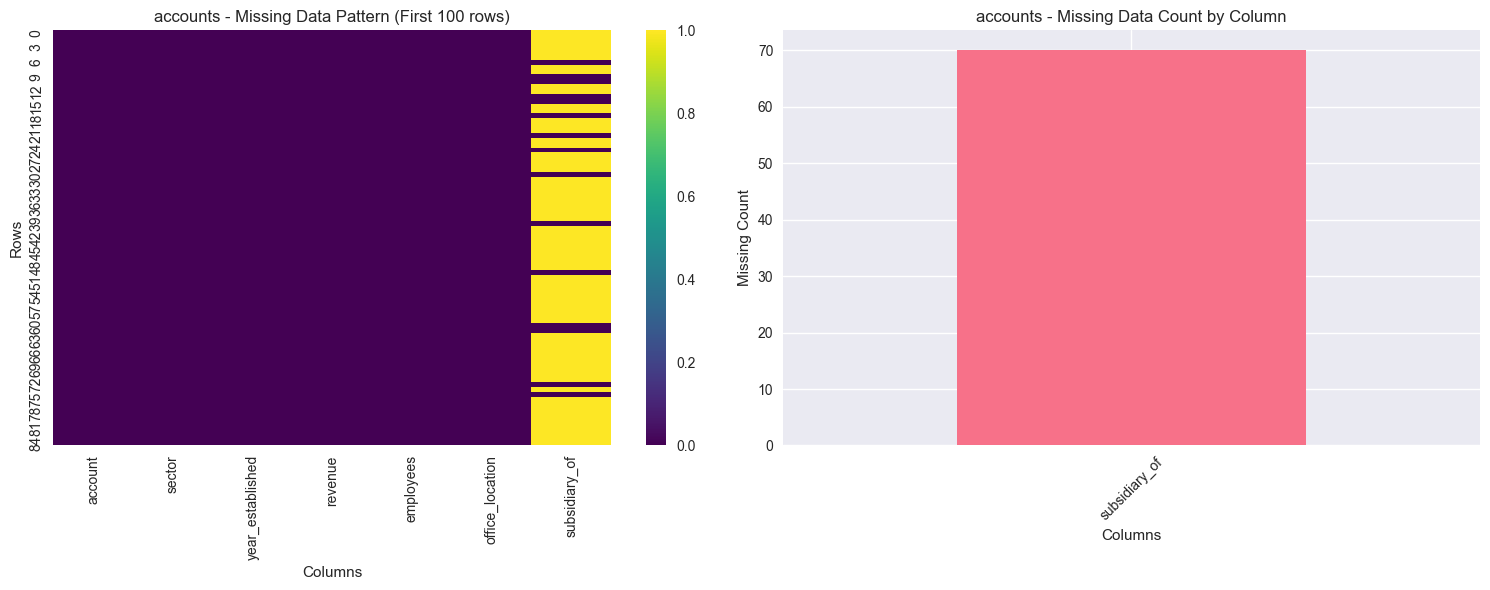


Analyzing missing patterns in PRODUCTS:
  No missing data detected

Analyzing missing patterns in SALES_PIPELINE:
  Missing data by column:
    account: 1,425 (16.2%)
    engage_date: 500 (5.7%)
    close_date: 2,089 (23.7%)
    close_value: 2,089 (23.7%)
  Strong missing data correlations:
    account ↔ close_date: 0.788
    account ↔ close_value: 0.788
    close_date ↔ close_value: 1.000


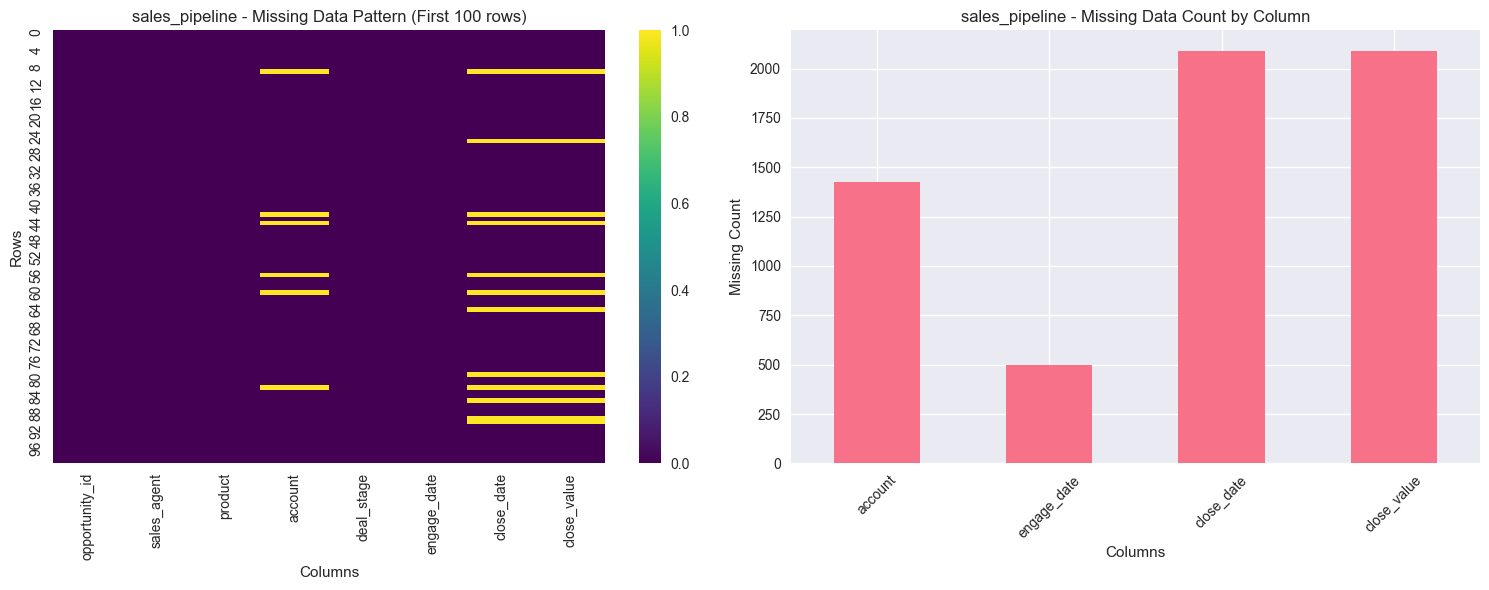


Analyzing missing patterns in SALES_TEAMS:
  No missing data detected

Analyzing missing patterns in DATA_DICTIONARY:
  No missing data detected


In [25]:
# Analyze missing data patterns
print("\nSTEP 3: MISSING DATA PATTERN ANALYSIS")
print("-" * 50)

missing_analyses = {}

for table_name, df in tables.items():
    print(f"\nAnalyzing missing patterns in {table_name.upper()}:")
    
    # Comprehensive missing data analysis
    missing_analysis = analyze_missing_patterns(df, table_name)
    missing_analyses[table_name] = missing_analysis
    
    if missing_analysis['missing_summary']:
        print("  Missing data by column:")
        for item in missing_analysis['missing_summary']:
            print(f"    {item['column']}: {item['missing_count']:,} ({item['missing_percentage']:.1f}%)")
        
        # Analyze missing data correlations
        if missing_analysis['missing_correlation'] is not None:
            corr_matrix = missing_analysis['missing_correlation']
            
            # Find high correlations between missing patterns
            high_correlations = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    corr_val = corr_matrix.iloc[i, j]
                    if abs(corr_val) > 0.5:  # Strong correlation threshold
                        high_correlations.append((
                            corr_matrix.columns[i],
                            corr_matrix.columns[j], 
                            corr_val
                        ))
            
            if high_correlations:
                print("  Strong missing data correlations:")
                for col1, col2, corr in high_correlations:
                    print(f"    {col1} ↔ {col2}: {corr:.3f}")
        
        # Create missing data visualizations
        visualize_missing_patterns(df, table_name)
    
    else:
        print("  No missing data detected")


#### Step 4: Apply imputations

In [26]:
# Apply intelligent imputation
print("\nSTEP 4: INTELLIGENT MISSING DATA IMPUTATION")
print("-" * 50)

imputation_log = {}

for table_name, df in tables.items():
    print(f"\nApplying imputation strategies to {table_name.upper()}:")
    
    df_imputed = df.copy()
    table_imputation_log = []
    
    # Get missing data analysis for this table
    missing_info = missing_analyses.get(table_name, {})
    missing_summary = missing_info.get('missing_summary', [])
    
    if not missing_summary:
        print("  No missing data to impute")
        continue
    
    for missing_item in missing_summary:
        column = missing_item['column']
        missing_count = missing_item['missing_count']
        data_type = missing_item['data_type']
        
        print(f"\n  Processing {column} ({missing_count:,} missing values):")
        
        original_missing = df_imputed[column].isnull().sum()
        
        # Choose imputation strategy based on data type and business context
        if table_name == 'accounts':
            if column == 'subsidiary_of':
                # Business logic: Most companies are independent
                df_imputed[column] = categorical_imputation(
                    df_imputed[column], strategy='custom', custom_value='Independent'
                )
                strategy_used = "Business logic: Independent companies"
            
            elif column in ['revenue', 'employees'] and 'sector' in df_imputed.columns:
                # Group-based numerical imputation
                df_imputed[column] = numerical_imputation(
                    df_imputed[column], strategy='group_median', 
                    group_by='sector', group_data=df_imputed
                )
                strategy_used = "Sector-based median imputation"
            
            else:
                # Default numerical or categorical imputation
                if pd.api.types.is_numeric_dtype(df_imputed[column]):
                    df_imputed[column] = numerical_imputation(
                        df_imputed[column], strategy='median'
                    )
                    strategy_used = "Median imputation"
                else:
                    df_imputed[column] = categorical_imputation(
                        df_imputed[column], strategy='mode'
                    )
                    strategy_used = "Mode imputation"
        
        elif table_name == 'sales_pipeline':
            if column == 'close_value' and 'deal_stage' in df_imputed.columns:
                # Business logic: Only Won deals should have close values
                won_median = df_imputed[df_imputed['deal_stage'] == 'Won']['close_value'].median()
                
                won_missing_mask = ((df_imputed['deal_stage'] == 'Won') & 
                                  df_imputed['close_value'].isnull())
                
                if won_missing_mask.any():
                    df_imputed.loc[won_missing_mask, 'close_value'] = won_median
                    strategy_used = f"Won deals imputed with median: ${won_median:,.0f}"
                else:
                    # For demonstration: impute Engaging deals with Won median
                    engaging_missing_mask = ((df_imputed['deal_stage'] == 'Engaging') & 
                                           df_imputed['close_value'].isnull())
                    if engaging_missing_mask.any():
                        df_imputed.loc[engaging_missing_mask, 'close_value'] = won_median
                        strategy_used = f"Engaging deals estimated with Won median: ${won_median:,.0f}"
                    else:
                        strategy_used = "No Won deals missing close_value"
            
            elif column in ['engage_date', 'close_date']:
                # Time series imputation using interpolation
                df_imputed[column] = pd.to_datetime(df_imputed[column], errors='coerce')
                df_imputed[column] = numerical_imputation(
                    df_imputed[column], strategy='interpolate'
                )
                strategy_used = "Temporal interpolation"
            
            elif column == 'account':
                # Use most frequent account for missing values
                df_imputed[column] = categorical_imputation(
                    df_imputed[column], strategy='mode'
                )
                strategy_used = "Most frequent account"
            
            else:
                # Default strategy based on data type
                if pd.api.types.is_numeric_dtype(df_imputed[column]):
                    df_imputed[column] = numerical_imputation(
                        df_imputed[column], strategy='median'
                    )
                    strategy_used = "Median imputation"
                else:
                    df_imputed[column] = categorical_imputation(
                        df_imputed[column], strategy='mode'
                    )
                    strategy_used = "Mode imputation"
        
        else:
            # Generic imputation for other tables
            if pd.api.types.is_numeric_dtype(df_imputed[column]):
                df_imputed[column] = numerical_imputation(
                    df_imputed[column], strategy='median'
                )
                strategy_used = "Median imputation"
            else:
                df_imputed[column] = categorical_imputation(
                    df_imputed[column], strategy='mode'
                )
                strategy_used = "Mode imputation"
        
        # Record imputation results
        final_missing = df_imputed[column].isnull().sum()
        values_imputed = original_missing - final_missing
        
        print(f"    Strategy: {strategy_used}")
        print(f"    Values imputed: {values_imputed:,}")
        print(f"    Remaining missing: {final_missing:,}")
        
        table_imputation_log.append({
            'column': column,
            'original_missing': original_missing,
            'values_imputed': values_imputed,
            'final_missing': final_missing,
            'strategy': strategy_used
        })
    
    tables[table_name] = df_imputed
    imputation_log[table_name] = table_imputation_log



STEP 4: INTELLIGENT MISSING DATA IMPUTATION
--------------------------------------------------

Applying imputation strategies to ACCOUNTS:

  Processing subsidiary_of (70 missing values):
    Strategy: Business logic: Independent companies
    Values imputed: 70
    Remaining missing: 0

Applying imputation strategies to PRODUCTS:
  No missing data to impute

Applying imputation strategies to SALES_PIPELINE:

  Processing account (1,425 missing values):
    Strategy: Most frequent account
    Values imputed: 1,425
    Remaining missing: 0

  Processing engage_date (500 missing values):
    Strategy: Temporal interpolation
    Values imputed: 500
    Remaining missing: 0

  Processing close_date (2,089 missing values):
    Strategy: Temporal interpolation
    Values imputed: 2,089
    Remaining missing: 0

  Processing close_value (2,089 missing values):
    Strategy: Engaging deals estimated with Won median: $1,117
    Values imputed: 1,589
    Remaining missing: 500

Applying imputa

#### Step 5: Detect and analyze outliers 


STEP 5: COMPREHENSIVE OUTLIER DETECTION
--------------------------------------------------

Outlier analysis for ACCOUNTS:

  Analyzing outliers in year_established:
    IQR: 0 outliers (0.0%)
    Z-Score: 0 outliers (0.0%)
    Modified Z-Score: 0 outliers (0.0%)
    Business context analysis:
      → Normal outlier rate


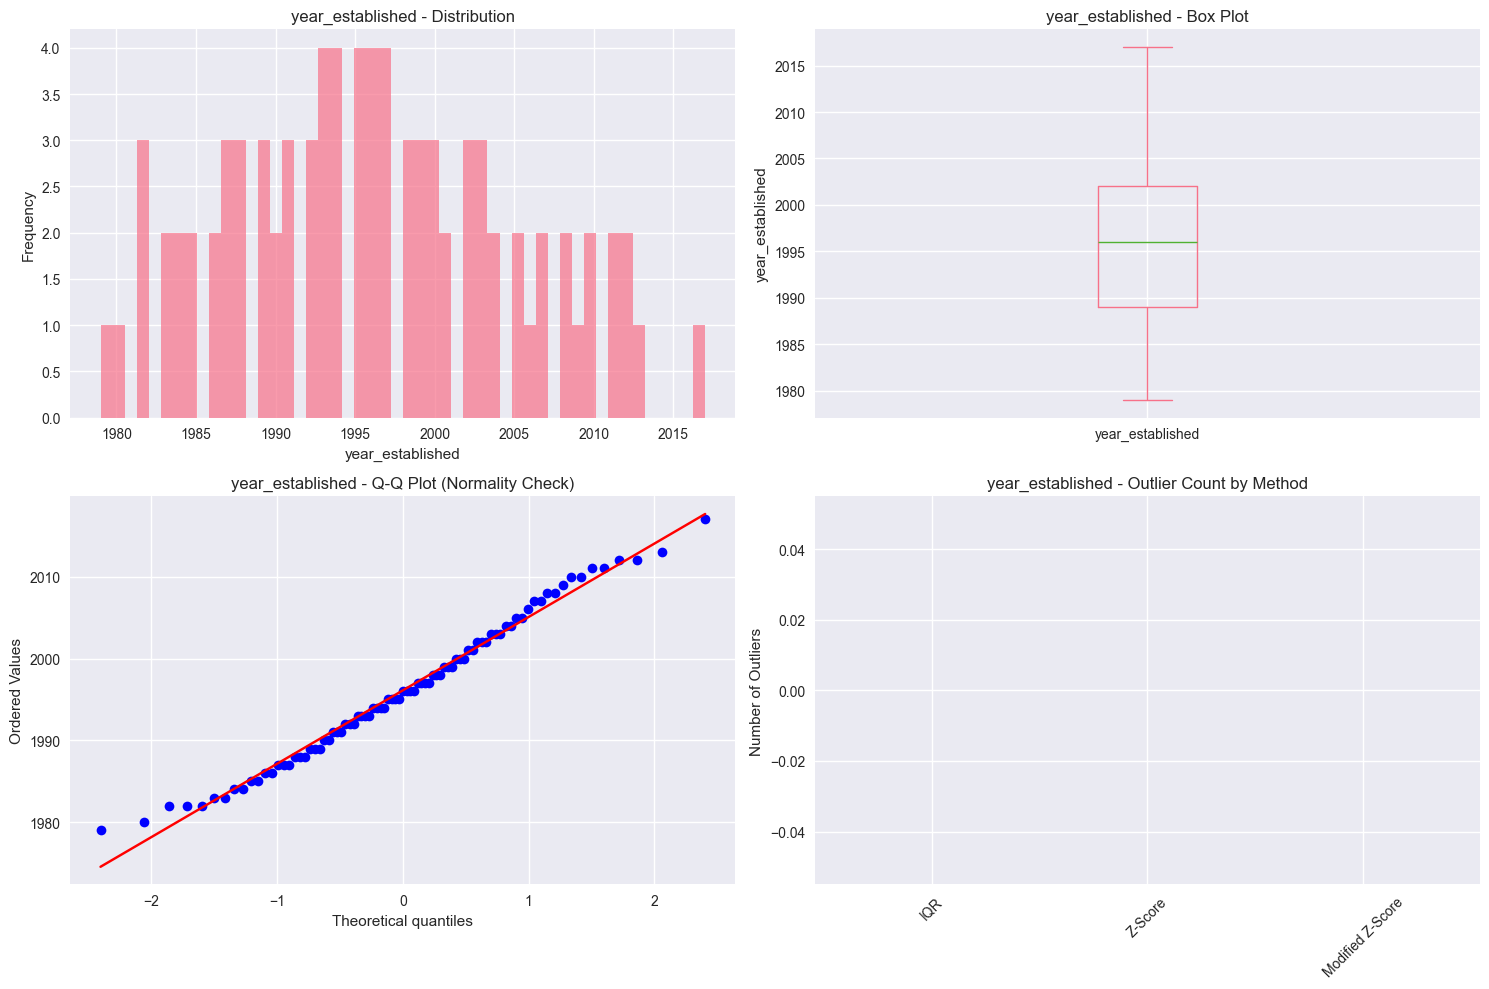


  Analyzing outliers in revenue:
    IQR: 6 outliers (7.1%)
    Z-Score: 1 outliers (1.2%)
    Modified Z-Score: 6 outliers (7.1%)
    Business context analysis:
      → Large revenue outliers expected (Fortune 500 companies)
      → Recommendation: RETAIN outliers (represent real business cases)


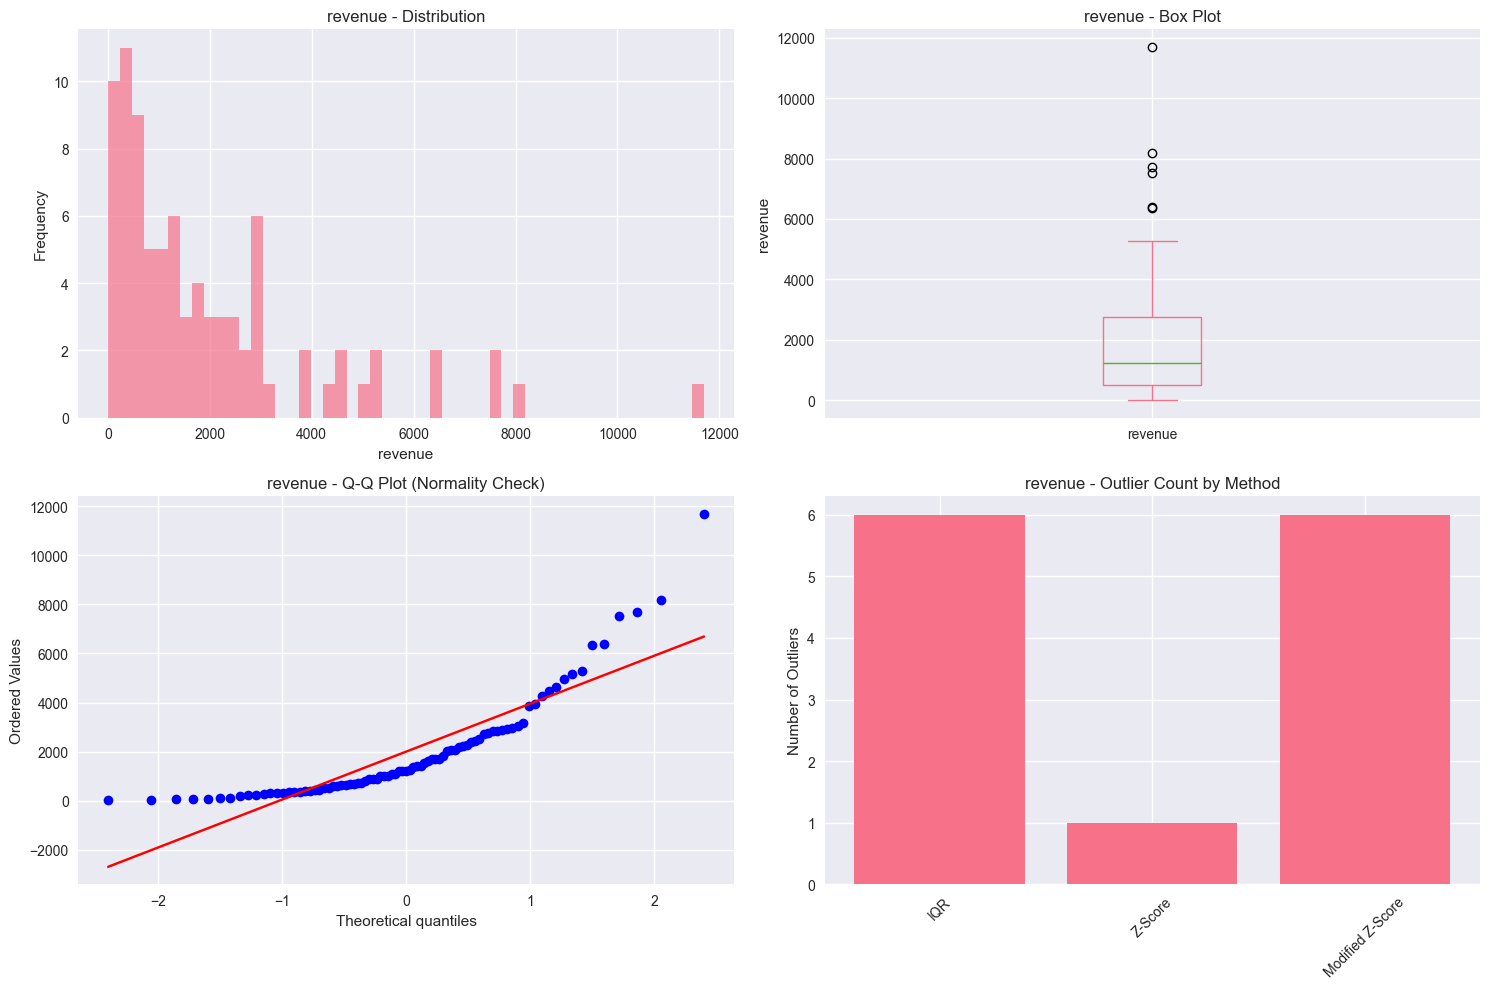


  Analyzing outliers in employees:
    IQR: 8 outliers (9.4%)
    Z-Score: 1 outliers (1.2%)
    Modified Z-Score: 8 outliers (9.4%)
    Business context analysis:
      → High outlier rate (9.4%) may indicate data quality issues
      → Recommendation: INVESTIGATE outliers


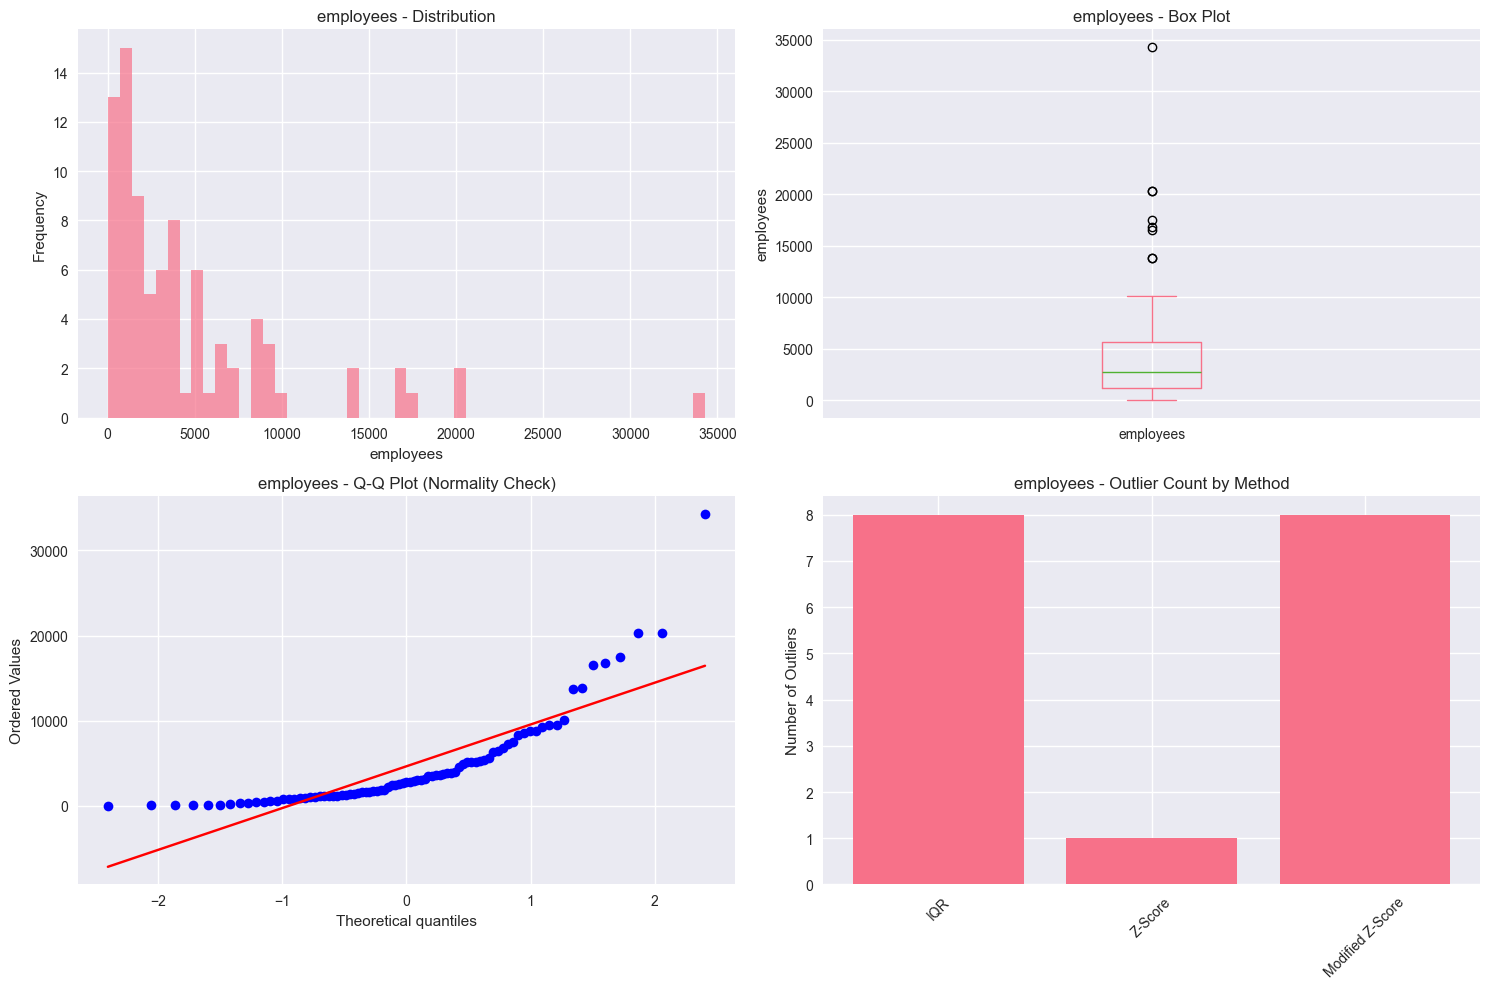


Outlier analysis for PRODUCTS:

Outlier analysis for SALES_PIPELINE:

  Analyzing outliers in close_value:
    IQR: 1844 outliers (22.2%)
    Z-Score: 15 outliers (0.2%)
    Modified Z-Score: 0 outliers (0.0%)
    Business context analysis:
      → High-value deals may be legitimate enterprise sales
      → Recommendation: REVIEW outliers with business stakeholders


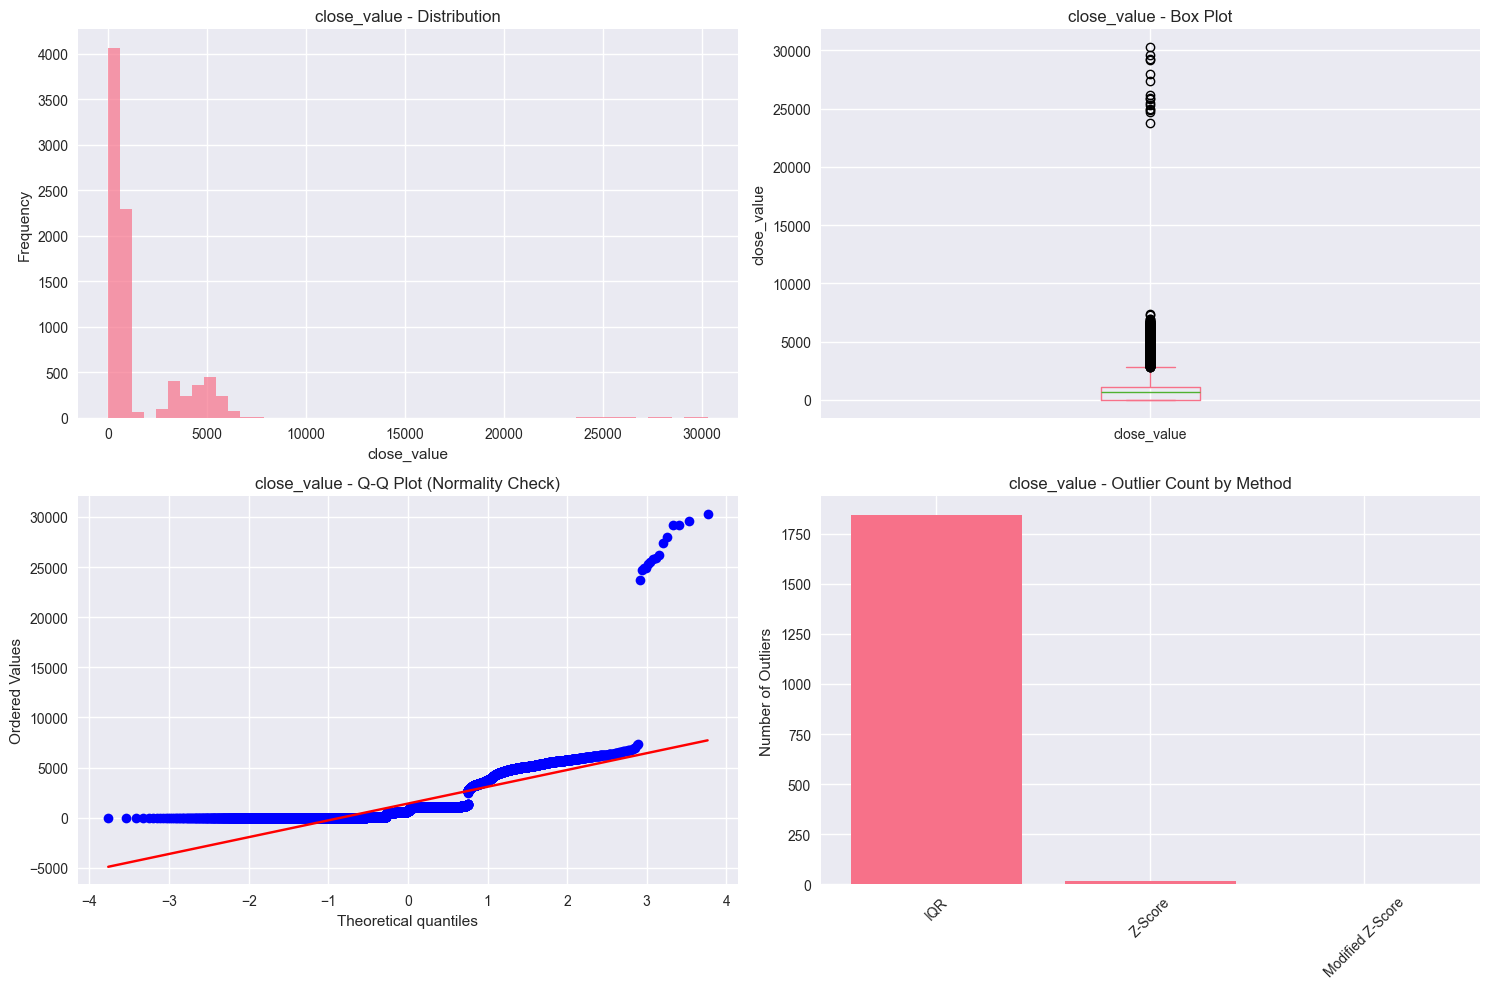


Outlier analysis for SALES_TEAMS:
  No numerical columns for outlier analysis

Outlier analysis for DATA_DICTIONARY:
  No numerical columns for outlier analysis


In [27]:
# Detect and analyze outliers
print("\nSTEP 5: COMPREHENSIVE OUTLIER DETECTION")
print("-" * 50)

outlier_analyses = {}

for table_name, df in tables.items():
    print(f"\nOutlier analysis for {table_name.upper()}:")
    
    # Focus on numerical columns for outlier detection
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    if len(numerical_cols) == 0:
        print("  No numerical columns for outlier analysis")
        continue
    
    table_outlier_results = {}
    
    for column in numerical_cols:
        if df[column].notna().sum() < 10:  # Skip columns with too few values
            continue
        
        print(f"\n  Analyzing outliers in {column}:")
        
        # Apply multiple outlier detection methods
        methods_results = {}
        
        # IQR method - robust and interpretable
        iqr_results = iqr_outlier_detection(df[column])
        methods_results['IQR'] = iqr_results
        
        # Z-score method - assumes normality
        zscore_results = zscore_outlier_detection(df[column])
        methods_results['Z-Score'] = zscore_results
        
        # Modified Z-score - robust to extreme outliers
        modified_zscore_results = modified_zscore_outlier_detection(df[column])
        methods_results['Modified Z-Score'] = modified_zscore_results
        
        # Report results for each method
        for method_name, results in methods_results.items():
            outlier_count = results['outlier_count']
            outlier_pct = (outlier_count / df[column].notna().sum()) * 100
            print(f"    {method_name}: {outlier_count} outliers ({outlier_pct:.1f}%)")
        
        # Business context analysis and recommendations
        print(f"    Business context analysis:")
        
        if table_name == 'accounts' and column == 'revenue':
            print("      → Large revenue outliers expected (Fortune 500 companies)")
            print("      → Recommendation: RETAIN outliers (represent real business cases)")
            treatment_recommendation = "retain"
        
        elif table_name == 'accounts' and column == 'employees':
            outlier_pct = (iqr_results['outlier_count'] / df[column].notna().sum()) * 100
            if outlier_pct > 5:
                print(f"      → High outlier rate ({outlier_pct:.1f}%) may indicate data quality issues")
                print("      → Recommendation: INVESTIGATE outliers")
                treatment_recommendation = "investigate"
            else:
                print("      → Normal outlier rate for employee counts")
                treatment_recommendation = "retain"
        
        elif table_name == 'sales_pipeline' and column == 'close_value':
            print("      → High-value deals may be legitimate enterprise sales")
            print("      → Recommendation: REVIEW outliers with business stakeholders")
            treatment_recommendation = "review"
        
        else:
            # Generic recommendation based on outlier percentage
            outlier_pct = (iqr_results['outlier_count'] / df[column].notna().sum()) * 100
            if outlier_pct > 10:
                print("      → High outlier rate suggests investigation needed")
                treatment_recommendation = "investigate"
            elif outlier_pct > 5:
                print("      → Moderate outlier rate - consider business context")
                treatment_recommendation = "review"
            else:
                print("      → Normal outlier rate")
                treatment_recommendation = "retain"
        
        # Create comprehensive visualizations
        visualize_outliers(df, column, methods_results)
        
        table_outlier_results[column] = {
            'methods_results': methods_results,
            'treatment_recommendation': treatment_recommendation
        }
    
    outlier_analyses[table_name] = table_outlier_results

#### Step 6: Data transformation

In [28]:
# Apply data transformations
print("\nSTEP 6: DATA TRANSFORMATION AND STANDARDIZATION")
print("-" * 50)

transformation_log = {}

# Define data type mappings based on business understanding
type_mappings = {
    'sales_pipeline': {
        'engage_date': 'datetime64',
        'close_date': 'datetime64',
        'close_value': 'float64'
    },
    'accounts': {
        'year_established': 'int64',
        'revenue': 'float64',
        'employees': 'int64'
    },
    'products': {
        'sales_price': 'float64'
    }
}

for table_name, df in tables.items():
    print(f"\nTransforming {table_name.upper()}:")
    
    # Standardize column names
    df_transformed, name_changes = standardize_column_names(df)
    
    if name_changes:
        print("  Column names standardized (lowercase, underscores)")
    else:
        print("  Column names already standardized")
    
    # Apply data type conversions
    table_type_mappings = type_mappings.get(table_name, {})
    if table_type_mappings:
        df_transformed, conversion_log = convert_data_types(
            df_transformed, table_type_mappings
        )
        
        print("  Data type conversions:")
        for column, log_entry in conversion_log.items():
            if log_entry['success']:
                print(f"    {column}: {log_entry['from']} → {log_entry['to']}")
            else:
                print(f"    {column}: Conversion failed - {log_entry['error']}")
    
    tables[table_name] = df_transformed
    transformation_log[table_name] = {
        'column_names_changed': name_changes,
        'type_conversions': conversion_log if table_type_mappings else {}
    }


STEP 6: DATA TRANSFORMATION AND STANDARDIZATION
--------------------------------------------------

Transforming ACCOUNTS:
  Column names already standardized
  Data type conversions:
    year_established: int64 → int64
    revenue: float64 → float64
    employees: int64 → int64

Transforming PRODUCTS:
  Column names already standardized
  Data type conversions:
    sales_price: int64 → int64

Transforming SALES_PIPELINE:
  Column names already standardized
  Data type conversions:
    engage_date: datetime64[ns] → datetime64[ns]
    close_date: datetime64[ns] → datetime64[ns]
    close_value: float64 → float64

Transforming SALES_TEAMS:
  Column names already standardized

Transforming DATA_DICTIONARY:
  Column names standardized (lowercase, underscores)


#### Step 7: Quality assessment


STEP 7: COMPREHENSIVE QUALITY ASSESSMENT
--------------------------------------------------

PROCESSING RESULTS SUMMARY:

Table           Original   Final      Improvement  Missing Before  Missing After  
-------------------------------------------------------------------------------------
accounts           88.2%    100.0%    +11.8%           70            0
products          100.0%    100.0%     +0.0%            0            0
sales_pipeline     91.3%     99.3%     +8.0%        6,103          500
sales_teams       100.0%    100.0%     +0.0%            0            0
data_dictionary   100.0%    100.0%     +0.0%            0            0
-------------------------------------------------------------------------------------
TOTAL IMPROVEMENT                                           5,673            0


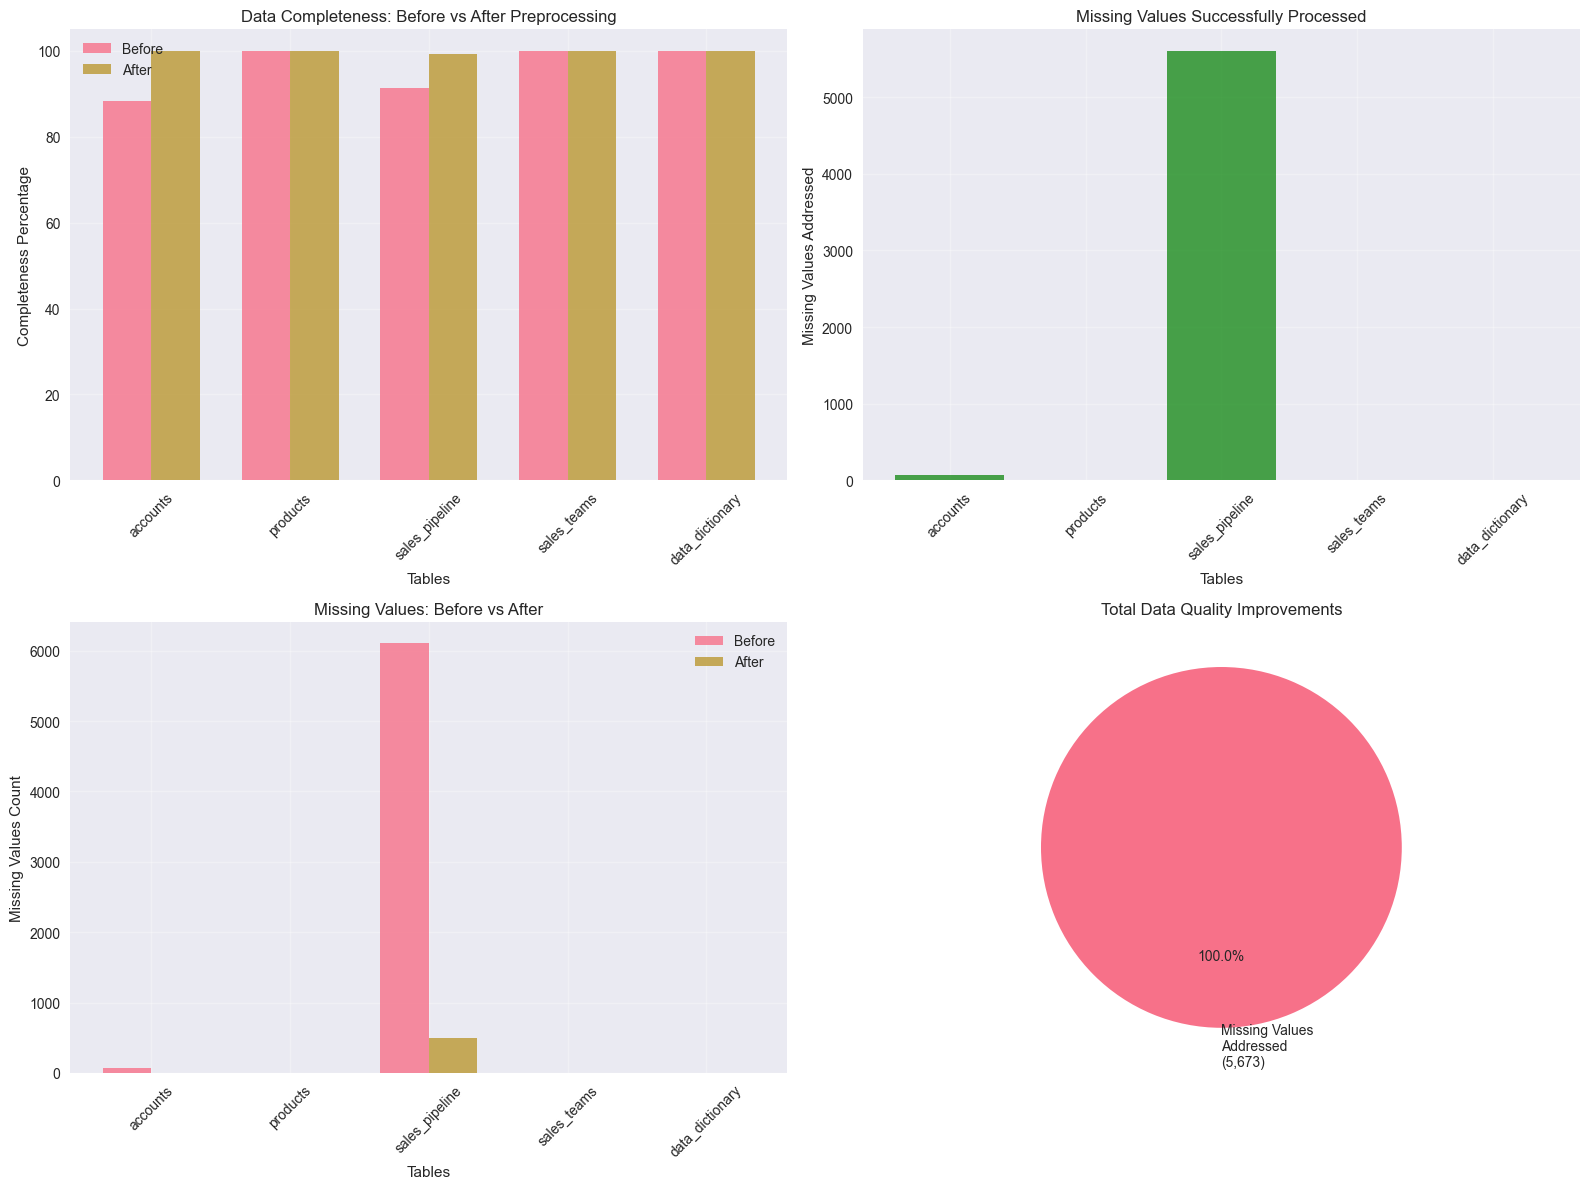

In [29]:
# Generate final quality report and visualization
print("\nSTEP 7: COMPREHENSIVE QUALITY ASSESSMENT")
print("-" * 50)

# Calculate final quality metrics
final_quality_metrics = []
for table_name, df in tables.items():
    final_metrics = assess_table_quality(df, table_name)
    final_quality_metrics.append(final_metrics)

# Compare initial and final metrics
print("\nPROCESSING RESULTS SUMMARY:")
print("=" * 40)

print(f"\n{'Table':<15} {'Original':<10} {'Final':<10} {'Improvement':<12} {'Missing Before':<15} {'Missing After':<15}")
print("-" * 85)

total_missing_improvement = 0
total_duplicates_removed = 0

for initial, final in zip(initial_quality_metrics, final_quality_metrics):
    table_name = initial['table_name']
    
    missing_improvement = initial['missing_cells'] - final['missing_cells']
    duplicate_improvement = initial['duplicate_rows'] - final['duplicate_rows']
    
    completeness_improvement = final['completeness_pct'] - initial['completeness_pct']
    
    print(f"{table_name:<15} {initial['completeness_pct']:>7.1f}% {final['completeness_pct']:>8.1f}% {completeness_improvement:>+8.1f}% {initial['missing_cells']:>12,} {final['missing_cells']:>12,}")
    
    total_missing_improvement += missing_improvement
    total_duplicates_removed += duplicate_improvement

print("-" * 85)
print(f"{'TOTAL IMPROVEMENT':<15} {'':<10} {'':<10} {'':<12} {total_missing_improvement:>12,} {total_duplicates_removed:>12,}")

# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Extract data for visualization
table_names = [metrics['table_name'] for metrics in initial_quality_metrics]
completeness_before = [metrics['completeness_pct'] for metrics in initial_quality_metrics]
completeness_after = [metrics['completeness_pct'] for metrics in final_quality_metrics]
missing_before = [metrics['missing_cells'] for metrics in initial_quality_metrics]
missing_after = [metrics['missing_cells'] for metrics in final_quality_metrics]

# Completeness improvement comparison
x = np.arange(len(table_names))
width = 0.35

axes[0,0].bar(x - width/2, completeness_before, width, label='Before', alpha=0.8)
axes[0,0].bar(x + width/2, completeness_after, width, label='After', alpha=0.8)
axes[0,0].set_xlabel('Tables')
axes[0,0].set_ylabel('Completeness Percentage')
axes[0,0].set_title('Data Completeness: Before vs After Preprocessing')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(table_names, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Missing values comparison
missing_reduced = [before - after for before, after in zip(missing_before, missing_after)]
axes[0,1].bar(table_names, missing_reduced, color='green', alpha=0.7)
axes[0,1].set_xlabel('Tables')
axes[0,1].set_ylabel('Missing Values Addressed')
axes[0,1].set_title('Missing Values Successfully Processed')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Before and after missing values
axes[1,0].bar(x - width/2, missing_before, width, label='Before', alpha=0.8)
axes[1,0].bar(x + width/2, missing_after, width, label='After', alpha=0.8)
axes[1,0].set_xlabel('Tables')
axes[1,0].set_ylabel('Missing Values Count')
axes[1,0].set_title('Missing Values: Before vs After')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(table_names, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Overall improvement summary
if total_missing_improvement > 0:
    axes[1,1].pie([total_missing_improvement], labels=[f'Missing Values\nAddressed\n({total_missing_improvement:,})'], 
                  autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Total Data Quality Improvements')
else:
    axes[1,1].text(0.5, 0.5, 'Data Quality\nAlready High', 
                  horizontalalignment='center', verticalalignment='center',
                  transform=axes[1,1].transAxes, fontsize=14)
    axes[1,1].set_title('Data Quality Status')

plt.tight_layout()
plt.show()

#### Step 8: Save preprocessed data

In [30]:
# Save processed tables
print("\nSTEP 8: SAVING PREPROCESSED DATA")
print("-" * 50)

output_path = Path('../data/interim/')
output_path.mkdir(parents=True, exist_ok=True)

print(f"Saving preprocessed tables to {output_path}:")
for table_name, df in tables.items():
    output_file = output_path / f"{table_name}_preprocessed.csv"
    df.to_csv(output_file, index=False)
    print(f"  Saved {table_name}_preprocessed.csv ({df.shape[0]:,} rows × {df.shape[1]} columns)")

print(f"\n" + "=" * 60)
print("COMPREHENSIVE PREPROCESSING PIPELINE COMPLETED")
print("=" * 60)
print(f"Total missing values addressed: {total_missing_improvement:,}")
print(f"Total duplicate rows removed: {total_duplicates_removed:,}")
print(f"Processed tables saved to: {output_path}")
print("Data is now ready for exploratory data analysis and modeling")


STEP 8: SAVING PREPROCESSED DATA
--------------------------------------------------
Saving preprocessed tables to ../data/interim:
  Saved accounts_preprocessed.csv (85 rows × 7 columns)
  Saved products_preprocessed.csv (7 rows × 3 columns)
  Saved sales_pipeline_preprocessed.csv (8,800 rows × 8 columns)
  Saved sales_teams_preprocessed.csv (35 rows × 3 columns)
  Saved data_dictionary_preprocessed.csv (21 rows × 3 columns)

COMPREHENSIVE PREPROCESSING PIPELINE COMPLETED
Total missing values addressed: 5,673
Total duplicate rows removed: 0
Processed tables saved to: ../data/interim
Data is now ready for exploratory data analysis and modeling
